In [1]:
import os
import sys
import csv
import json
import moment
import pymysql
import datetime

import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict

from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter

%matplotlib inline

## Create a plot to display rates of mortality and intubation across groups

In [2]:
# data_file_name = 'data/pandas_df_v3_2020-04-25.pkl'
data_file_name = 'data/pandas_df_v3-1_2020-04-25.pkl'

df = pd.read_pickle(data_file_name)
_version, date_retrieved = data_file_name.split('_df_')[1].split('.')[0].split('_')
print(_version, date_retrieved)

v3-1 2020-04-25


In [9]:
# outcome = 'intubated'
# days_to = 'days_to_intubation'
# outcome_name = 'Intubation'

outcome = 'died'
days_to = 'days_to_death'
outcome_name = 'Mortality'

In [10]:
# NaN indicate people who were not covid positive
covidpos = df.dropna()

# remove patients who were intubated before they were diagnosed
covidpos = covidpos[covidpos["days_to_intubation"] >= 0]

# remove patients that died before they were diagnosed
covidpos = covidpos[covidpos["days_to_death"] >= 0]

# remove patients who were intubated or died more than 30 days later
covidpos = covidpos[covidpos["days_to_intubation"] < 90]
covidpos = covidpos[covidpos["days_to_death"] < 90]

# add some binary age variables
covidpos['age_over_65'] = (covidpos['age'] > 65)+1-1

covidpos.describe()

,pat_mrn_id,intubated,days_to_intubation,died,days_to_death,age,sex,macula,compl_def,coagulation,...,refctrl,race_black,race_asian,race_white,race_other,race_declined,eth_hispanic,eth_nonhispanic,eth_declinedother,age_over_65
count,6.397000e+03,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,...,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000,6397.000000
mean,1.095011e+09,0.075191,19.607629,0.085040,19.901516,57.134029,0.497264,0.013756,0.000625,0.184305,...,0.113647,0.221510,0.023136,0.283727,0.280131,0.191496,0.339534,0.369079,0.291387,0.375020
std,1.319922e+08,0.263721,11.330646,0.278963,11.141045,19.877320,0.500032,0.116487,0.025000,0.387763,...,0.317407,0.415295,0.150347,0.450841,0.449098,0.393509,0.473588,0.482593,0.454437,0.484166
min,1.000011e+09,0.000000,0.000000,0.000000,0.000000,0.002738,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.004378e+09,0.000000,11.000000,0.000000,11.000000,41.478439,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.009221e+09,0.000000,20.000000,0.000000,20.000000,58.510609,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.200224e+09,0.000000,28.000000,0.000000,28.000000,72.005476,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.400038e+09,1.000000,84.000000,1.000000,83.000000,120.202601,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
def propci(p, n):
    s = np.sqrt((p*(1-p)/n))
    return (p, p-1.96*s, p+1.96*s)

In [12]:
covariates = [
    ('macula', 'Macula'),
    ('compl_def', 'Compl Deficiency'),
    ('coagulation', 'Coagulation' ),
    ('hypertension', 'Hypertension'),
    ('type2_diabetes', 'T2D'),
    ('obesity', 'Obesity'),
    ('cad', 'CAD'),
    ('sex', 'Sex (Male)'),
    ('age_over_65', 'Age (>65 yrs)'),
    ('refctrl', 'Cough')
]

results = list()

for covar, covar_name in covariates:
    p = covidpos[covidpos[covar]==1][outcome].mean()
    n = covidpos[covar].sum()
    p, plo, pup = propci(p, n)
    print(covar, n, p, plo, pup)
    
    results.append((p, plo, pup, n, covar_name))
    
results = sorted(results)

macula 88 0.25 0.15952775413019044 0.34047224586980956
compl_def 4 0.0 0.0 0.0
coagulation 1179 0.14673452078032231 0.12653656553110548 0.16693247602953915
hypertension 1922 0.1675338189386056 0.15083776175403238 0.18422987612317884
type2_diabetes 847 0.19716646989374262 0.17037209387254448 0.22396084591494075
obesity 791 0.1264222503160556 0.10326268681434095 0.14958181381777028
cad 1566 0.16922094508301405 0.15065017043261833 0.18779171973340977
sex 3181 0.09839673058786545 0.08804596889278907 0.10874749228294184
age_over_65 2399 0.1909128803668195 0.17518550667159108 0.20664025406204792
refctrl 727 0.10729023383768914 0.08479325991993626 0.129787207755442


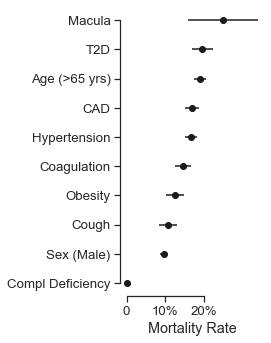

In [13]:
x = range(len(results))
y, ylo, yup, n, covar = zip(*results)

ylo = [yi-yj for yi, yj in zip(y, ylo)]
yup = [yj-yi for yi, yj in zip(y, yup)]

sns.set(style='ticks', font_scale=1.2)

plt.figure(figsize=(4,5))

plt.errorbar(y, x, xerr=[ylo, yup], fmt='ko', )

plt.xlabel('%s Rate' % outcome_name)
plt.yticks(x, covar, rotation=0)
plt.xticks([0, 0.1, 0.2], ['0', '10%', '20%'])
sns.despine(trim=True)

plt.tight_layout()

plt.savefig('figures/outcome_rates_%s_%s_%s.pdf' % (outcome, _version, date_retrieved))